# Point

* Demonstrate asynchronous grey trust formation.
* Compare against solo/sliding window trust

## TODO
* Check that resultant weights are normalised (i.e. sum=1) - *DONE - All Metrics are fine but partials are flawed*


In [8]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import operator
import pandas as pd
from bounos.Analyses.Weight import summed_outliers_per_weight
import bounos.ChartBuilders as cb

import os
import pandas as pd

_ = np.seterr(invalid='ignore') # Pandas PITA Nan printing

import sklearn.ensemble as ske

def categorise_dataframe(df):
    # Categories work better as indexes
    for obj_key in df.keys()[df.dtypes == object]:
        try:
            df[obj_key] = df[obj_key].astype('category')
        except TypeError:
            print("Couldn't categorise {}".format(obj_key))
            pass
    return df

def feature_extractor(df, target):
    data = df.drop(target, axis=1)
    reg = ske.RandomForestRegressor(n_jobs=4, n_estimators=512)
    reg.fit(data, df[target])
    return pd.Series(dict(zip(data.keys(), reg.feature_importances_)))

def target_weight_feature_extractor(target_weights):
    known_good_features_d = {}
    for basekey in target_weights.keys(): # Parallelisable
        print basekey
        # Single DataFrame of all features against one behaviour
        var_weights = target_weights.apply(lambda s: s/target_weights[basekey], axis=0).dropna()
        known_good_features_d[basekey] = \
            pd.concat([feature_extractor(s.reset_index(),var) for var,s  in var_weights.iteritems()],
                      keys=var_weights.keys(), names=['var','metric'])
            
    return known_good_features_d


def dataframe_weight_filter(df, keys):
    indexes = [(df.index.get_level_values(k)==0.0) for k in keys]
    return df.loc[reduce(operator.and_,indexes)]

phys_keys = ['INDD','INHD','Speed']
comm_keys = ['ADelay','ARXP','ATXP','RXThroughput','TXThroughput','PLR']
observer = 'Bravo'
target = 'Alfa'
n_nodes = 6
n_metrics = 9

var_rename_dict = {'CombinedBadMouthingPowerControl':'MPC',
 'CombinedSelfishTargetSelection':'STS',
 'CombinedTrust':'Fair',
 'Shadow':'Shadow',
 'SlowCoach':'SlowCoach'}

results_path = "/home/bolster/src/aietes/results/Malicious Behaviour Trust Comparison-2015-07-20-17-47-53"

fig_basedir = "/home/bolster/src/thesis/papers/active/16_AAMAS/img"

assert os.path.isdir(fig_basedir)

def non_zero_rows(df):
    return df[~(df==0).all(axis=1)]


def map_level(df, dct, level=0):
    index = df.index
    index.set_levels([[dct.get(item, item) for item in names] if i==level else names
                      for i, names in enumerate(index.levels)], inplace=True)


#Graphics

In [9]:
#print(matplotlib.rcParams)
_boxplot_kwargs = {
    'showmeans':True,
    'showbox':False,
    'widths':0.2,
    'linewidth':2
}

golden_mean  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
w=4
cb.latexify(columns=0.5, factor=0.5)

(3.339, 2.0636154884358993)

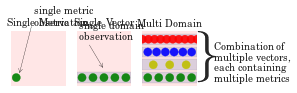

In [10]:
def add_height_annotation(ax, start, end, txt_str, x_width=.5, txt_kwargs=None, arrow_kwargs=None):
    """
    Adds horizontal arrow annotation with text in the middle

    Parameters
    ----------
    ax : matplotlib.Axes
        The axes to draw to

    start : float
        start of line

    end : float
        end of line

    txt_str : string
        The text to add

    y_height : float
        The height of the line

    txt_kwargs : dict or None
        Extra kwargs to pass to the text

    arrow_kwargs : dict or None
        Extra kwargs to pass to the annotate

    Returns
    -------
    tuple
        (annotation, text)
    """

    if txt_kwargs is None:
        txt_kwargs = {}
    if arrow_kwargs is None:
        # default to your arrowprops
        arrow_kwargs = {'arrowprops':dict(arrowstyle="<->",
                            connectionstyle="bar",
                            ec="k",
                            shrinkA=5, shrinkB=5,
                            )}

    trans = ax.get_xaxis_transform()

    ann = ax.annotate('', xy=(x_width, start),
                        xytext=(x_width, end),
                        transform=trans,
                        **arrow_kwargs)
    txt = ax.text(x_width + .05,
                  (start + end) / 2,
                  txt_str,
                  **txt_kwargs)



fig, axes = plt.subplots(nrows=1,ncols=3, sharex='none', sharey='none',
                         subplot_kw={'axisbg':(1,0.9,0.9), 'alpha':0.1})
#fig.suptitle("Threat Surface for Trust Management Frameworks", size=18, x=0.6, y=0.73)
for ax in axes:
    ax.set_aspect('equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
ys = np.linspace(0.15,0.85,4)

# Single
ax=axes[0]
ax.set_title("Single Metric")
ax.add_patch(pylab.Circle((0.1,ys[0]),radius=0.075,color='g', alpha=0.9))
ax.annotate('single metric\nobservation', xy=(0.15,0.2), xycoords='data',
                xytext=(15,50), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc,angleA=0180,armA=30,rad=10"),
                )    


# Vector
ax=axes[1]
ax.set_title("Single Vector")
ax.add_patch(pylab.Rectangle((0.0,ys[0]-0.1),0.99,0.2, alpha=0.2))
for x in np.linspace(0.1,0.9,5):
    ax.add_patch(pylab.Circle((x,ys[0]),radius=0.075,color='g', alpha=0.9))
ax.annotate('single domain\nobservation', xy=(0.5,0.3), xycoords='data',
                xytext=(-25,30), textcoords='offset points',
                arrowprops=dict(arrowstyle="->",
                                connectionstyle="arc,angleA=0180,armA=30,rad=10"),
                ) 


#Multi
ax=axes[2]
ax.set_title("Multi Domain")
ax.text(1,0.3,r"$\}$",fontsize = 52)
ax.text(1.3,0.42,"Combination of\nmultiple vectors,\neach containing\nmultiple metrics",
        verticalalignment='center')

ax.add_patch(pylab.Rectangle((0.0,ys[0]-0.1),0.99,0.2, alpha=0.2))
for x in np.linspace(0.1,0.9,5):
    ax.add_patch(pylab.Circle((x,ys[0]),radius=0.075,color='g', alpha=0.9))

ax.add_patch(pylab.Rectangle((0.0,ys[1]-0.1),0.99,0.2, alpha=0.2))
for x in np.linspace(0.2,0.8,3):
    ax.add_patch(pylab.Circle((x,ys[1]),radius=0.075,color='y', alpha=0.9))

ax.add_patch(pylab.Rectangle((0.0,ys[2]-0.1),1.0,0.2, alpha=0.2))
for x in np.linspace(0.1,0.9,6):
    ax.add_patch(pylab.Circle((x,ys[2]),radius=0.075,color='b', alpha=0.9))

ax.add_patch(pylab.Rectangle((0.0,ys[3]-0.1),1.0,0.2, alpha=0.2))
for x in np.linspace(0,1,10):
    ax.add_patch(pylab.Circle((x,ys[3]),radius=0.075,color='r', alpha=0.9))

fig.savefig(os.path.join(fig_basedir, 'threat_surface_sum'), transparent=True)

In [11]:
with pd.get_store(results_path+"/outliers.bkup.h5") as store:
    target_weights_dict = {}
    for runkey in store.keys():
        print runkey
        target_weights_dict[runkey] = summed_outliers_per_weight(store.get(runkey), observer, n_metrics, target=target)
        
joined_target_weights = pd.concat(target_weights_dict, names = ['run']+target_weights_dict[runkey].index.names)
sorted_joined_target_weights = joined_target_weights.reset_index('run', drop=True).sort()

/CombinedTrust0_3
/CombinedTrust1_3
/CombinedTrust2_3


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: FutureWarning: sort(....) is deprecated, use sort_index(.....)


# All Metrics - Fair Base Behaviour

In [12]:
joined_feats = target_weight_feature_extractor(sorted_joined_target_weights)

alt_joined_feats= pd.concat(joined_feats, names=['base','comp','metric']).unstack('metric')[comm_keys+phys_keys]
alt_joined_feats.index.set_levels([[u'MPC', u'STS', u'Fair', u'Shadow', u'SlowCoach'], [u'MPC', u'STS', u'Fair', u'Shadow', u'SlowCoach']], inplace=True)


CombinedBadMouthingPowerControl
CombinedSelfishTargetSelection
CombinedTrust
Shadow
SlowCoach


In [13]:
shared_h5_path = '/dev/shm/shared.h5'
alt_joined_feats.to_hdf(shared_h5_path,'alt_joined_feats')
joined_target_weights.to_hdf(shared_h5_path,'joined_target_weights')
sorted_joined_target_weights.to_hdf(shared_h5_path, 'sorted_joined_target_weights')

/home/bolster/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:252: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis1_level0] [items->None]

  f = lambda store: store.put(key, value, **kwargs)
/home/bolster/anaconda2/lib/python2.7/site-packages/pandas/io/pytables.py:252: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->unicode,key->axis1_level1] [items->None]

  f = lambda store: store.put(key, value, **kwargs)


{'$Speed$': (0.65323955669224243, 0.0, 1.0, 1.0), '$INDD$': (0.0, 0.56159420289855033, 1.0, 1.0), '$P_{RX}$': (1.0, 0.43137254901960792, 0.0, 1.0), '$T^P_{RX}$': (0.36036036036036034, 1.0, 0.0, 1.0), '$INHD$': (0.056479113384484365, 0.0, 1.0, 1.0), '$PLR$': (0.0, 1.0, 0.84334809192494242, 1.0), '$P_{TX}$': (0.9750927397986221, 1.0, 0.0, 1.0), '$Delay$': (1.0, 0.0, 0.16, 1.0), '$T^P_{TX}$': (0.0, 1.0, 0.23192072527935917, 1.0)}
file encoding: None
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec}
\usepackage{pgfplots}


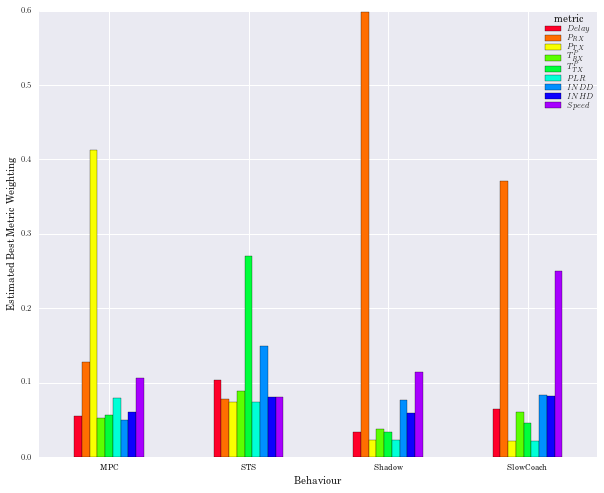

In [46]:
metric_rename_dict = {
    'ADelay': "$Delay$",
    'ARXP': "$P_{RX}$",
    'ATXP': "$P_{TX}$",
    'RXThroughput': "$T^P_{RX}$",
    'TXThroughput': "$T^P_{TX}$",
    'PLR': '$PLR$',
    'INDD': '$INDD$',
    'INHD': '$INHD$',
    'Speed': '$Speed$'
}
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib2tikz import save as tikz_save


def unique_cm_dict_from_list(items):
    cm = plt.get_cmap('gist_rainbow')
    cNorm  = colors.Normalize(vmin=0, vmax=len(items))
    scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
    
    return dict(zip(items,[scalarMap.to_rgba(i) for i in range(len(items))]))
metric_colour_map = unique_cm_dict_from_list(fair_feats.keys().tolist())
print metric_colour_map

these_feature_colours = [metric_colour_map[k] for k in fair_feats.keys().tolist()]


fair_feats = alt_joined_feats.loc['Fair'].rename(columns=metric_rename_dict)
ax = fair_feats[~(fair_feats==0).all(axis=1)].plot(kind='bar', colors=these_feature_colours, rot=0, label="Test", figsize=(10,8))
ax.set_xlabel("Behaviour")
ax.set_ylabel("Estimated Best Metric Weighting")
fig=ax.get_figure()
#ax.get_figure().savefig(os.path.join(fig_basedir,"full_metric_trust_relevance"), transparent=True)
tikz_save('mytikz.tex', figure=fig, draw_rectangles=True);
plt.show()


file encoding: None
Please add the following lines to your LaTeX preamble:

\usepackage[utf8]{inputenc}
\usepackage{fontspec}
\usepackage{pgfplots}


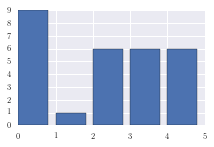

In [50]:
import matplotlib.pyplot as plt
from matplotlib2tikz import save as tikzsave

plt.bar(range(5), [np.random.randint(10) for _ in range(5)])
tikzsave("testplot.tex", draw_rectangles=True)

In [ ]:
fair_feats = alt_joined_feats.loc['Fair']
plottables = fair_feats[~(fair_feats==0)]
plt.bar(plot)
ax.set_xlabel("Behaviour")
ax.set_ylabel("Estimated Best Metric Weighting")

ax.get_figure().savefig(os.path.join(fig_basedir,"full_metric_trust_relevance"), transparent=True)

In [ ]:
fair_feats.head()

In [ ]:
from scipy.stats.stats import pearsonr
import itertools

key_order = ['ADelay', 'ARXP', 'ATXP', 'RXThroughput', 'TXThroughput', 'PLR', 'INDD', 'INHD','Speed']
def calc_correlations(base, comp, index=0):
    dp_r=(comp/base).reset_index()
    return dp_r.corr()[index][:-1]

#calc_correlations(sorted_joined_target_weights.CombinedTrust,sorted_joined_target_weights.CombinedBadMouthingPowerControl)
_corrs = {}
for base, comp in itertools.permutations(sorted_joined_target_weights.keys(), 2):
    _corrs[(base,comp)]= \
    calc_correlations(sorted_joined_target_weights[base],
                      sorted_joined_target_weights[comp])

In [ ]:
corrs = pd.DataFrame.from_dict(_corrs).rename(index=metric_rename_dict)
corrs = corrs.T
map_level(corrs, var_rename_dict, 0)
map_level(corrs, var_rename_dict, 1)
corrs.index.set_names(['base','comp'],inplace=True)
corrs.loc['Fair'].apply(lambda v: np.round(v,decimals=3)).to_latex()

# Comms Only - Fair Base Behaviour

In [ ]:
reset_phys_keys = sorted_joined_target_weights.reset_index(level=phys_keys)
zero_phys_indexes = (reset_phys_keys[phys_keys]==0.0).all(axis=1)
comms_only_target_weights = reset_phys_keys[zero_phys_indexes].drop(phys_keys,1)

comms_only_feats = target_weight_feature_extractor(comms_only_target_weights)

In [ ]:
alt_comms_only_feats= pd.concat(comms_only_feats, names=['base','comp','metric']).unstack('metric')[comm_keys]
alt_comms_only_feats.index.set_levels([[u'MPC', u'STS', u'Fair', u'Shadow', u'SlowCoach'], [u'MPC', u'STS', u'Fair', u'Shadow', u'SlowCoach']], inplace=True)
alt_comms_only_feats.to_hdf(shared_h5_path, 'alt_comms_only_feats')
fair_feats = alt_comms_only_feats.loc['Fair']
ax = fair_feats[~(fair_feats==0).all(axis=1)].plot(kind='bar', rot=0, label="Test")
ax.set_xlabel("Behaviour")
ax.set_ylabel("Estimated Best Metric Weighting")

ax.get_figure().savefig(os.path.join(fig_basedir,"comms_metric_trust_relevance"), transparent=True)

# Phys Only - Fair Base Behaviour

In [ ]:
reset_comm_keys = sorted_joined_target_weights.reset_index(level=comm_keys)
zero_comm_indexes = (reset_comm_keys[comm_keys]==0.0).all(axis=1)
phys_only_target_weights = reset_comm_keys[zero_comm_indexes].drop(comm_keys,1)

phys_only_feats = target_weight_feature_extractor(phys_only_target_weights)

In [ ]:
alt_phys_only_feats= pd.concat(phys_only_feats, names=['base','comp','metric']).unstack('metric')[phys_keys]
alt_phys_only_feats.index.set_levels([[u'MPC', u'STS', u'Fair', u'Shadow', u'SlowCoach'], [u'MPC', u'STS', u'Fair', u'Shadow', u'SlowCoach']], inplace=True)
alt_phys_only_feats.to_hdf(shared_h5_path, 'alt_phys_only_feats')

fair_feats = alt_phys_only_feats.loc['Fair']
ax = fair_feats[~(fair_feats==0).all(axis=1)].plot(kind='bar', rot=0, label="Test")
ax.set_xlabel("Behaviour")
ax.set_ylabel("Estimated Best Metric Weighting")

ax.get_figure().savefig(os.path.join(fig_basedir,"phys_metric_trust_relevance"), transparent=True)

In [ ]:
pd.concat(comms_only_feats, names=['base','comp','metric']).unstack('metric')[comm_keys]

# Feature Values

In [ ]:

feat_detection_weights=non_zero_rows(alt_joined_feats).T
#categorise_dataframe(feat_detection_weights).to_hdf('/dev/shm/shared.h5','all_metric_feat_weights')


In [ ]:
signed_feat_detection_weights = feat_detection_weights*corrs.apply(np.sign).T
categorise_dataframe(signed_feat_detection_weights).to_hdf('/dev/shm/shared.h5','signed_all_metric_feat_weights')

In [ ]:
phys_only_target_weights.head()

In [ ]:
sorted_joined_target_weights.head()

In [ ]:
[] is None

In [ ]:
feat_detection_weights.sum()